## A circuit approach to a Bit-flip Repetition Code

Strategy:

- **Initialize:**
We prepare the state $|\Psi_0\rangle \rightarrow |\Psi_1\rangle = (\alpha |0\rangle + \beta |1\rangle)$

- **Encode:**
Map our state $|\Psi_1\rangle = (\alpha |0\rangle + \beta |1\rangle)$ using our encoding $U_{en}|\Psi_1\rangle$ to the state $ (\alpha |000\rangle + \beta |111\rangle)$.


- **Measure stabilizers:** 
We introduce stabilizer bits. Measuring the stabilizers must tell us if a bit flip error occurred and on which of the 3 encoding qubits it happened. This gives us the error syndroms.

- **Correcting errors**:
Use dynamic circuits to use our syndrome measurements in order to correct potential errors.

- **Decode:**
Use the complex conjugate of the encoding: $U_{en}^{\dagger}(\alpha |000\rangle + \beta |111\rangle) \rightarrow |\Psi_1\rangle = (\alpha |0\rangle + \beta |1\rangle)$.

In [1]:
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer, AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.visualization import plot_histogram


import warnings

warnings.filterwarnings("ignore")

import math

pi = math.pi

### 1) Initialize

In [2]:
# Setup a base quantum circuit for our experiments
encoding = QuantumRegister(3,name='encoding')
stabilizer = QuantumRegister(2,name='stabilizer')

encoding_q0, encoding_q1, encoding_q2 = encoding
stabilizer_q0, stabilizer_q1 = stabilizer

# Results of the encoding
results = ClassicalRegister(3,name='result')

result_b0, result_b1, result_b2 = results

# For measuring the stabilizer
syndrome = ClassicalRegister(2,name='syndrome')

syndrome_b0, syndrome_b1 = syndrome

# The actual qubit which is encoded
state = encoding[0]

# The ancillas used for encoding the state
ancillas = encoding[1:]


# Initializing
def initialize_circuit() -> QuantumCircuit:
    return QuantumCircuit(encoding, stabilizer, results, syndrome)

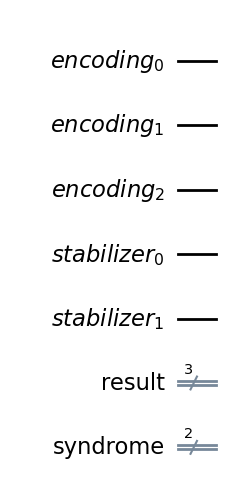

In [ ]:
# Initialize the circuit and apply an X-Gate on the first encoding Qubit

# Your code goes here: 
initial_state = initialize_circuit()
initial_state.draw(output="mpl")

### 2) Encoding

Propaga the information among all encoding qubits. 
The result is an entangled state: When one qubit is measured, the outcome of the other 2 qubits is known.

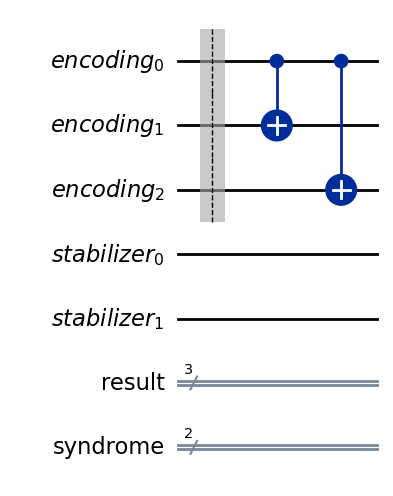

In [4]:
# Encoding using bit flip code
def encode_bit_flip(qc, state, ancillas):
    qc.barrier(state, *ancillas)
    # Propagate the state that is encoded in the first qubit to the ancilla qubits
    # Your code goes here: 
    [qc.cx(state, ancilla) for ancilla in ancillas]
    return qc


# The circuit encodes our qubit
encoding_circuit = encode_bit_flip(initialize_circuit(), state, ancillas)

# The circuit including all parts so far
complete_circuit = initial_state.compose(encoding_circuit)
complete_circuit.draw(output="mpl")

### 3) Measure stabilizers

Compute syndrome bits, such that they can be measured to detect single bitflip errors. Afterwards reset the stabilizer qubits to the `0` state.

Let’s get a stabilizer with the simplest possible encoding:

`00` -> No error occurred 

`01` -> An error occurred  in qubit 0 (the first qubit)

`10` -> An error occurred  in qubit 1 (the second qubit)

`11` -> An error occurred  in qubit 2 (the third qubit)

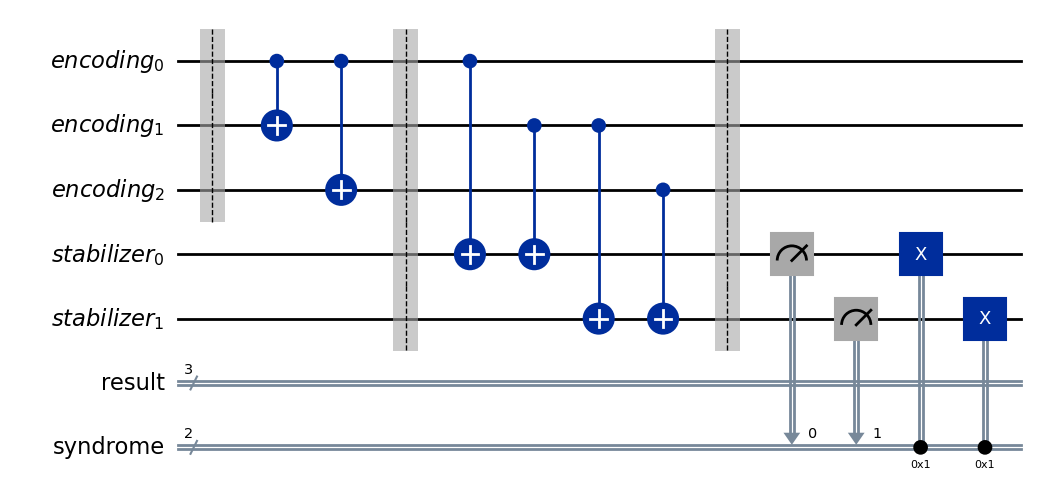

In [8]:
def measure_syndrome_bit(qc, encoding, stabilizer):
    qc.barrier()
    encoding_q0, encoding_q1, encoding_q2 = encoding
    stabilizer_q0, stabilizer_q1 = stabilizer

    # Encode the error in the stabilizer qubits: 
    # Your code goes here:
     # 1 = 01 = first qubit (qubit 0) flipped
     # 2 = 10 second qubit (qubit 1) flipped
     # 3 = 11 = third qubit (qubit 2) flipped
     # 3 = 11 = third qubit (qubit 2) flipped
    qc.cx(encoding_q0, stabilizer_q0)
    qc.cx(encoding_q1, stabilizer_q0)
    qc.cx(encoding_q1, stabilizer_q1)
    qc.cx(encoding_q2, stabilizer_q1)
    

    qc.barrier()
    qc.measure(stabilizer, syndrome)

    # Reset the stabilizers after measurement (if they were flipped they must be set to |0> again)
    # Your code goes here:
    qc.x(stabilizer).c_if(syndrome, 1)


    return qc


syndrome_circuit = measure_syndrome_bit(initialize_circuit(), encoding, stabilizer)

complete_circuit = initial_state.compose(encoding_circuit).compose(syndrome_circuit)
complete_circuit.draw("mpl")

### 4 Correcting Errors

We will now use dynamic circuits on our syndrome measurements in order to correct potential errors.

Since we chose our syndrome measurements above in a clever way, it should now be quite easy to correct the errors, since we know exactly which of the qubits is flipped, for the case of a single error.

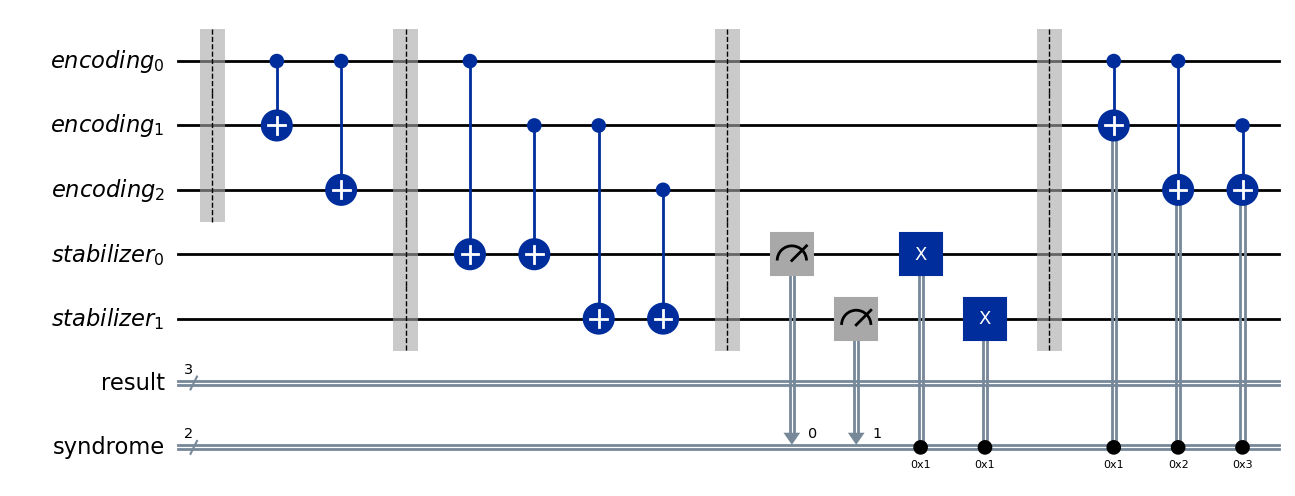

In [10]:
# Correct the errors, remember how we encoded the errors above!
def apply_correction_bit(qc, encoding, syndrome):
    qc.barrier()
    encoding_q0, encoding_q1, encoding_q2 = encoding

    # Your code goes here:
    # correct for encoding 0 flip 
    # correct for encoding 1 flip
    # correct for encoding 2 flip
    qc.cx(encoding_q0, encoding_q1).c_if(syndrome, 1)
    qc.cx(encoding_q0, encoding_q2).c_if(syndrome, 2)
    qc.cx(encoding_q1, encoding_q2).c_if(syndrome, 3)
    return qc


correction_circuit = apply_correction_bit(initialize_circuit(), encoding, syndrome)
complete_circuit = (
    initial_state.compose(encoding_circuit)
    .compose(syndrome_circuit)
    .compose(correction_circuit)
)
complete_circuit.draw(output="mpl")


### 5) Decoding

For decoding the original state, we must build a decoder which does the opposite, so a decoder $U_{de}|\Psi_0\rangle$ which maps $ (\alpha |000\rangle + \beta |111\rangle)$. to   $|\Psi_1\rangle = (\alpha |0\rangle + \beta |1\rangle)$ 

Since it does exactly the opposite, we can invert our encoder:

$U_{de} = U_{en}^\dagger$

In [11]:
def decode_bit_flip(qc, state, ancillas):
    qc.barrier(state, *ancillas)
    for ancilla in ancillas:
        qc.cx(state, ancilla)
    return qc
decoding_circuit = decode_bit_flip(initialize_circuit(), state, ancillas)

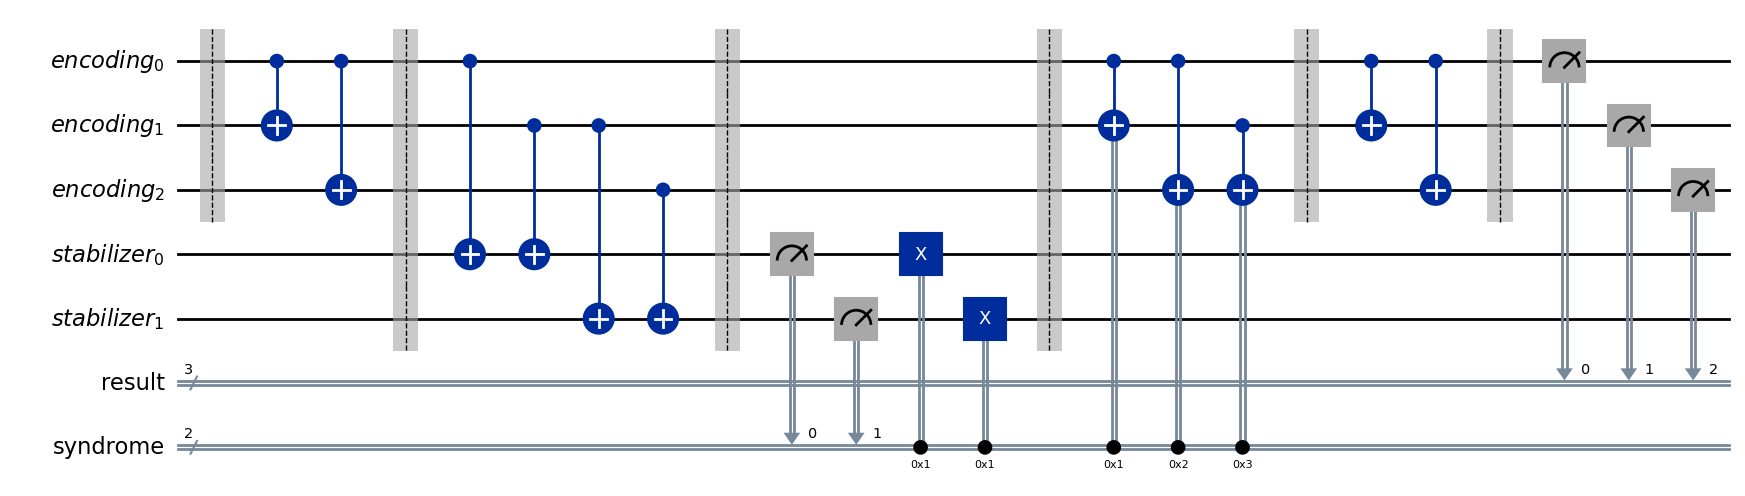

In [12]:
def apply_final_readout(qc, encoding, results):
    qc.barrier(encoding)
    qc.measure(encoding, results)
    return qc
    


measuring_circuit = apply_final_readout(initialize_circuit(), encoding, results)
complete_circuit = (
    initial_state.compose(encoding_circuit)
    .compose(syndrome_circuit)
    .compose(correction_circuit)
    .compose(decoding_circuit)
    .compose(measuring_circuit)
)
complete_circuit.draw(output="mpl")

### Testing

Let's create noise in a controlled way and test bit-flip error correction code

For testing purposes, we build a circuit, which introduces some errors, but in a controlled way:

- We want to introduce bit flip errors, since that is what we are correcting

- We want that the errors on the 3 encoding qubits are independent of each other

- We want that we can choose how high the probability is that errors are introduced

- We want to have our input in percentage, and the output should be a circuit which generates errors with that probability.

**Hint**

When applying a $R_x(\alpha)$ gate on $|0>$ the probabilities of measuring 0 and 1 are as follows: 

- $P(|0>) = cos^2 \left( \frac{\alpha}{2} \right) \rightarrow \alpha = 2 asin \left( \sqrt{p} \right)$ 
- $P(|1>) =sin^2 \left( \frac{\alpha}{2} \right)$

In [13]:
# Add some errors as defined above (only add errors to the encoding qubits)
def make_some_noise(qc, encoding, syndrome, error_percentage):
    encoding_q0, encoding_q1, encoding_q2 = encoding
    syndrome_b0, syndrome_b1 = syndrome
    # Convert error percentage to x-rotation angle
    p = error_percentage/100
    angle = 2*math.asin(math.sqrt(p))
    qc.rx(angle,encoding)

    return qc

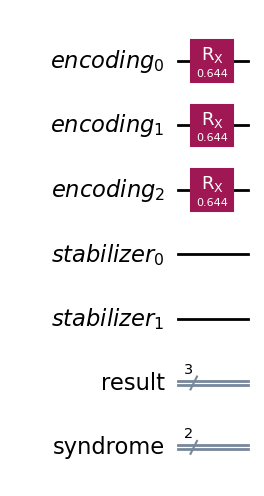

In [14]:
error_percentage = 10
noise_circuit = make_some_noise(initialize_circuit(), encoding, syndrome, error_percentage)
noise_circuit.draw(output="mpl")

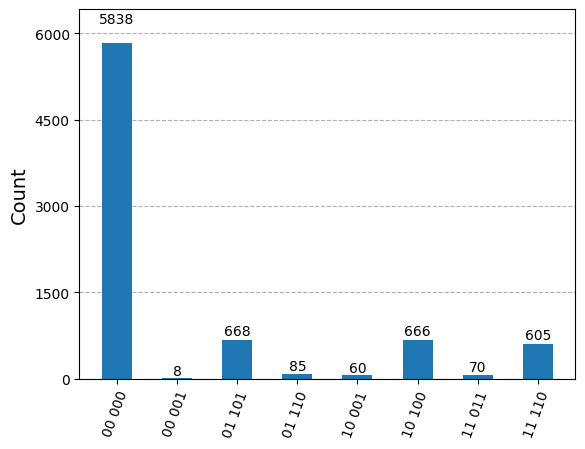

In [16]:
qc_test_error = (
    initial_state.compose(encoding_circuit)
    .compose(noise_circuit)
    .compose(syndrome_circuit)
    .compose(correction_circuit)
    .compose(decoding_circuit)
    .compose(measuring_circuit)
)



shots = 8000
aer_backend = AerSimulator()
# let the simulation run
counts = aer_backend.run(qc_test_error, shots=shots).result().get_counts()
# and plot our results
plot_histogram(counts)

**Note:** All bit strings that include the sequence "001" in the encoding qubits are valid. The syndrom qubits indicate which qubit has fliped in the experiment due the error we have set.

In [17]:
print(f"Error probability of bit flip: p={error_percentage/100}")
print(f"Actual error with rep. code: {1 - sum(value for key, value in counts.items() if '001' in key)/shots}")
print(f"Expected error with rep. code: {3*(error_percentage/100)**2-2*(error_percentage/100)**3}")

Error probability of bit flip: p=0.1
Actual error with rep. code: 0.9915
Expected error with rep. code: 0.028000000000000004
